### Proyecto de Laboratorio de Mineria de Datos
---
**Contexto**:<br>
Una empresa minorista quiere implementar un **sistema de recomendación de productos personalizado**. El primer paso es **clasificar a los clientes en diferentes categorías (por ejemplo, "alto valor", "frecuente", "ocasional", etc.)** basándose en datos históricos de compras y comportamiento de los usuarios. Una vez que se entrena el modelo de clasificación, debe ser desplegado para que el equipo de marketing pueda usarlo en tiempo real.

In [1]:
# librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# transformación de datos
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Separar datos para train y test
from sklearn.model_selection import train_test_split

# modelo de datos y métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# serializar el modelo
import joblib

# Desarrollo de una API
from flask import Flask, request, jsonify
from threading import Thread
import json
import os
import requests

In [2]:
df = pd.read_csv('data/synthetic_customer_data.csv')
df.head()

,customer_id,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
0,CUST_0001,56,Male,65648,49624.926758,17,467.729972,52.525842,0,235,61,medium_value
1,CUST_0002,69,Male,123537,46357.348299,196,874.799829,11.120875,0,182,48,medium_value
2,CUST_0003,46,Male,145991,27043.860801,175,207.419293,86.816930,0,199,50,medium_value
3,CUST_0004,32,Female,29516,42117.461389,25,131.749484,29.736153,0,356,32,medium_value
4,CUST_0005,60,Male,132863,26095.803066,94,289.081236,16.253799,1,245,29,high_value


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               1000 non-null   object 
 1   age                       1000 non-null   int64  
 2   gender                    1000 non-null   object 
 3   annual_income             1000 non-null   int64  
 4   total_spent               1000 non-null   float64
 5   num_purchases             1000 non-null   int64  
 6   avg_purchase_value        1000 non-null   float64
 7   online_activity_score     1000 non-null   float64
 8   loyalty_program           1000 non-null   int64  
 9   days_since_last_purchase  1000 non-null   int64  
 10  num_site_visits           1000 non-null   int64  
 11  customer_segment          1000 non-null   object 
dtypes: float64(3), int64(6), object(3)
memory usage: 93.9+ KB


In [4]:
for i in df.columns:
    if df[i].nunique() < 10:
        print(f'COLUMN: {i}')
        print(f'UNIQUE VALUES: {df[i].unique()}\n')

COLUMN: gender
UNIQUE VALUES: ['Male' 'Female']

COLUMN: loyalty_program
UNIQUE VALUES: [0 1]

COLUMN: customer_segment
UNIQUE VALUES: ['medium_value' 'high_value' 'low_value']



---
### ♻️ Transformación de los datos

1. Transformar la columna categórica "gender" a númerica con `OneHotEncoder`

In [5]:
# Guardando dataframe original

original_df = df.copy()

In [6]:
# Crear una instancia del OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

encoded_data = encoder.fit_transform(df[['gender']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['gender']))

df = pd.concat([df.drop(['gender'], axis = 1), encoded_df], axis=1)
df

,customer_id,age,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment,gender_Female,gender_Male
0,CUST_0001,56,65648,49624.926758,17,467.729972,52.525842,0,235,61,medium_value,0.0,1.0
1,CUST_0002,69,123537,46357.348299,196,874.799829,11.120875,0,182,48,medium_value,0.0,1.0
2,CUST_0003,46,145991,27043.860801,175,207.419293,86.816930,0,199,50,medium_value,0.0,1.0
3,CUST_0004,32,29516,42117.461389,25,131.749484,29.736153,0,356,32,medium_value,1.0,0.0
4,CUST_0005,60,132863,26095.803066,94,289.081236,16.253799,1,245,29,high_value,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CUST_0996,60,92982,8430.959128,156,731.840015,61.506463,1,15,43,medium_value,1.0,0.0
996,CUST_0997,64,122747,35680.997927,73,139.678658,17.567210,0,333,44,medium_value,0.0,1.0
997,CUST_0998,62,75922,33352.632138,120,201.651024,51.318989,0,58,7,medium_value,1.0,0.0
998,CUST_0999,35,68231,48305.770506,56,184.615637,71.538102,0,176,79,medium_value,0.0,1.0


---
### ✂️ Dividir dataset en conjuntos de entrenamiento y validación

In [7]:
X = df.drop(['customer_id','customer_segment'], axis = 1)
y = df['customer_segment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
for x,i in zip('X_train, X_test, y_train, y_test'.split(', '), [X_train, X_test, y_train, y_test]):
    print(f'{x}\t{i.shape}')

X_train	(800, 11)
X_test	(200, 11)
y_train	(800,)
y_test	(200,)


---
### 🌳 Desarrollar modelo (Random Forest)

In [9]:
# Crear un modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

---
### 💯 Entrenar y evaluar el modelo

In [10]:
# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 98.00%


In [11]:
# Reporte de clasificación
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

  high_value       1.00      0.86      0.92        28
medium_value       0.98      1.00      0.99       172

    accuracy                           0.98       200
   macro avg       0.99      0.93      0.96       200
weighted avg       0.98      0.98      0.98       200



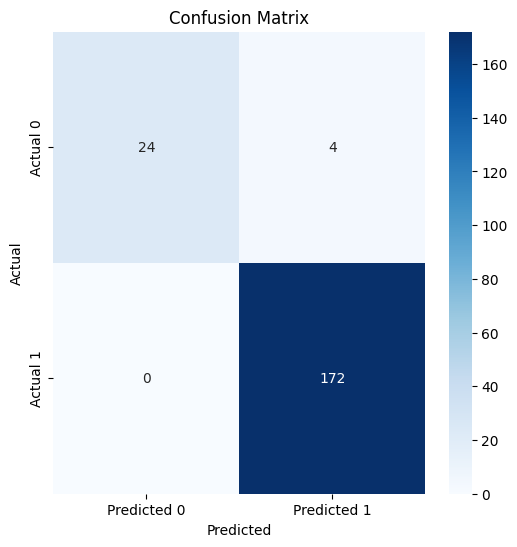

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Crea un mapa de calor usando seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

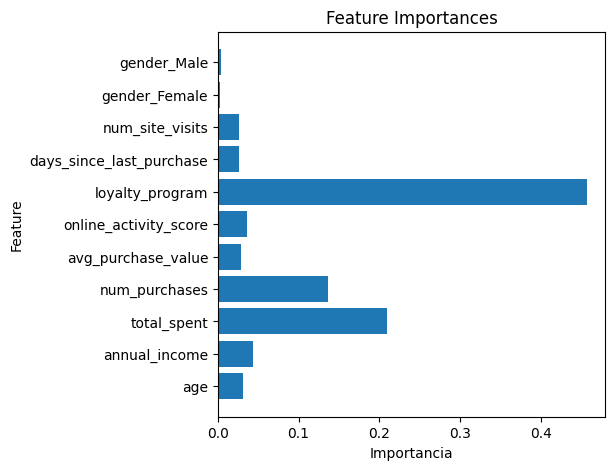

In [13]:
# Obtener la importancia de las características
feature_names = rf_model.feature_names_in_
feature_importances = rf_model.feature_importances_

# Visualizar la importancia de las características
plt.figure(figsize=(5, 5))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

---
### 🛠️ Ajustar hiperparámetros
Vamos a probar utilizar entropy como criterio, y vamos a buscar algún random_state que de un número muy alto, aún mas alto que el inicial.

In [14]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [15]:
random_states = []

# for n in range(0,100):
for n in range(0,1):
    # Crear un modelo de Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state = n, criterion = 'entropy')

    # Entrenar el modelo
    rf_model.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred = rf_model.predict(X_test)

    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > 0.99:
        print(f"Precisión del modelo {n}: {accuracy * 100:.2f}%")

In [16]:
# Crear un modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=75, criterion = 'entropy')

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Reporte de clasificación
class_report = classification_report(y_test, y_pred)
print(class_report)

Precisión del modelo: 99.50%
              precision    recall  f1-score   support

  high_value       1.00      0.96      0.98        28
medium_value       0.99      1.00      1.00       172

    accuracy                           0.99       200
   macro avg       1.00      0.98      0.99       200
weighted avg       1.00      0.99      0.99       200



### ⬆️ Exportar el modelo (Joblib)

In [17]:
ruta = 'models/random_forest_model.pkl'

joblib.dump(rf_model, ruta)

['models/random_forest_model.pkl']

In [18]:
rf_model

RandomForestClassifier(criterion='entropy', random_state=75)

### 👨‍💻 Desarrollando una API de prueba 

In [19]:
# Cargando modelo del pkl
model = joblib.load(ruta)
model

RandomForestClassifier(criterion='entropy', random_state=75)

In [20]:
# Instancia de la aplicación de Flask
app = Flask(__name__)

@app.route("/", methods = ['GET'])
def index():
    return "Método GET de comprobación"

# Define una ruta en el servidor Flask que responde a las solicitudes HTTP POST
@app.route("/predict", methods = ['POST'])

def predict():
    try:
        data = request.get_json(force=True)  # Obtiene los datos del request en formato JSON
        
        if not data:
            return jsonify({'error': 'No data provided'}), 400
        
        # Convertir el género a one-hot encoding
        gender = data['gender']
        gender_female = 1.0 if gender == 'Female' else 0.0
        gender_male = 1.0 if gender == 'Male' else 0.0
        
        # Formatear los datos en el formato que el modelo espera
        features = [
            data['age'], data['annual_income'], data['total_spent'], 
            data['num_purchases'], data['avg_purchase_value'], data['online_activity_score'], 
            data['loyalty_program'], data['days_since_last_purchase'], data['num_site_visits'], 
            gender_female, gender_male
        ]
        
        # Realiza la predicción
        prediction = model.predict([features])
        
        # Devuelve la predicción en formato JSON
        return jsonify({'prediction': prediction.tolist()})
    
    except Exception as e:
        return jsonify({'error': str(e)}), 500

def run_app():
    app.run(host = '0.0.0.0', port = 5000)

thread = Thread(target = run_app)
thread.start()

 * Serving Flask app '__main__'
 * Debug mode: off


In [21]:
url = 'http://127.0.0.1:5000/predict'

usuario_test = {
  "age": 56,
  "gender": "Male",
  "annual_income": 65648,
  "total_spent": 49624,
  "num_purchases": 17,
  "avg_purchase_value": 467,
  "online_activity_score": 52,
  "loyalty_program": 0,
  "days_since_last_purchase": 235,
  "num_site_visits": 61
}

response = requests.post(url, json = usuario_test)

print(response.json())

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.7:5000
Press CTRL+C to quit
C:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
127.0.0.1 - - [14/Nov/2024 02:13:34] "POST /predict HTTP/1.1" 200 -


{'prediction': ['medium_value']}


In [22]:
url = 'http://127.0.0.1:5000/predict'

usuario_test = {
    "age": 18,
    "gender": "Female",
    "annual_income": 133092,
    "total_spent": 3228,
    "num_purchases": 13,
    "avg_purchase_value": 553,
    "online_activity_score": 54,
    "loyalty_program": 0,
    "days_since_last_purchase": 57,
    "num_site_visits": 55
  }

response = requests.post(url, json = usuario_test)

print(response.json())

C:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
127.0.0.1 - - [14/Nov/2024 02:13:34] "POST /predict HTTP/1.1" 200 -


{'prediction': ['low_value']}
